# MULTISPECTRAL RESTART

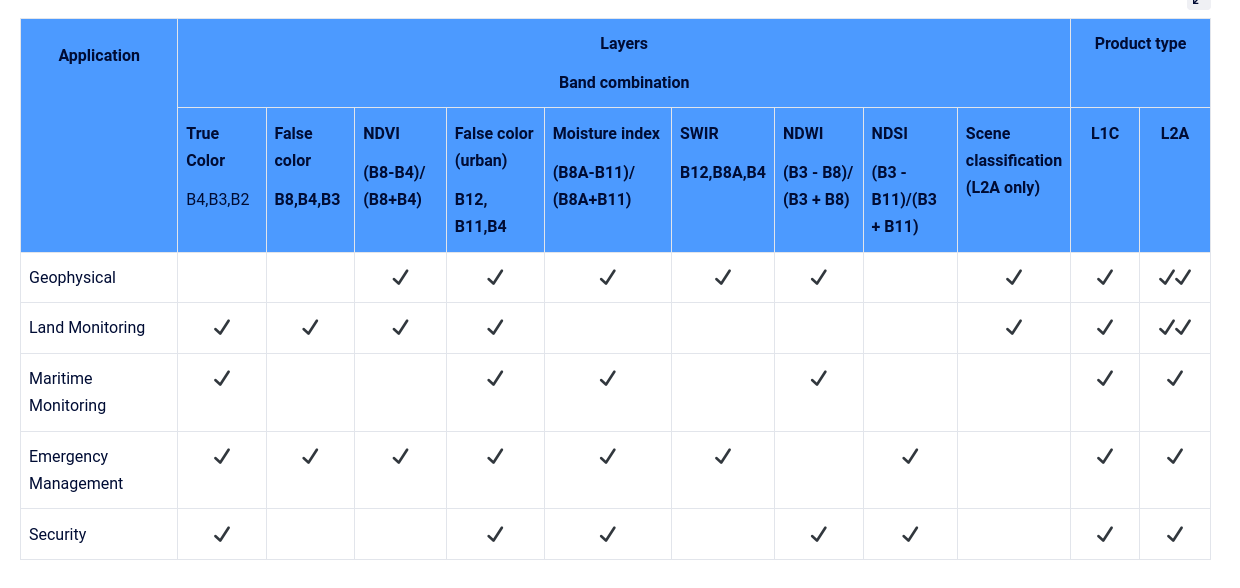

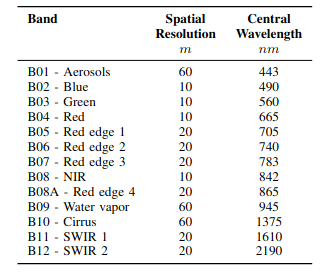

In [1]:
from datasets import load_dataset, Image
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# load a custom dataset from local/remote files or folders using the ImageFolder feature

# option 1: local/remote files (supporting the following formats: tar, gzip, zip, xz, rar, zstd)
#dataset = load_dataset("imagefolder", data_files="EuroSAT_MS.zip").cast_column("image", Image(decode=False))
#dataset = load_dataset("imagefolder", data_files="/home/pablo.canosa/finetuning_trials/EuroSAT_MS").cast_column("image", Image(decode=False))
dataset = load_dataset("imagefolder", data_dir="/home/pablo.canosa/finetuning_trials/EuroSAT_MS").cast_column("image", Image(decode=False))
#dataset = load_dataset("blanchon/EuroSAT_MSI")#.cast_column("image", Image(decode=False))
#dataset = load_dataset("imagefolder", data_files="EuroSAT_RGB.zip")
dataset['train'][0]['image']

Resolving data files:   0%|          | 0/27000 [00:00<?, ?it/s]

{'bytes': None,
 'path': '/home/pablo.canosa/finetuning_trials/EuroSAT_MS/AnnualCrop/AnnualCrop_1.tif'}

In [2]:
dataset['train'][0]["image"]['path']

'/home/pablo.canosa/finetuning_trials/EuroSAT_MS/AnnualCrop/AnnualCrop_1.tif'

In [3]:

# Define a transformation function to reduce channels
def reduce_channels(example):
    path = example['image']['path']  # Assuming 'image' is the key for the images in the dataset
    ds = gdal.Open(path)
    image = ds.ReadAsArray()
    image = np.moveaxis(image, 0, -1)
    reduced_image = image[:, :, [9, 3, 2, 1]]  # NIRRGB  ¿?  BGRNIR is the format for 16 bits in fivebillionpixels
    example['raw_data'] = reduced_image
    return example

# Apply the transformation to the dataset
dataset = dataset.map(reduce_channels)

<class 'list'>


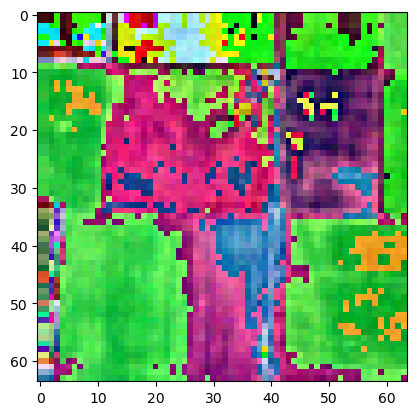

In [4]:
fourchannelimg = dataset['train'][0]['raw_data']
print(type(fourchannelimg))
img = np.array(fourchannelimg)
img = img.astype(np.uint8)
plt.imshow(img[:, :, [1,2,3]])# NIR R G B supuestamente
plt.show()

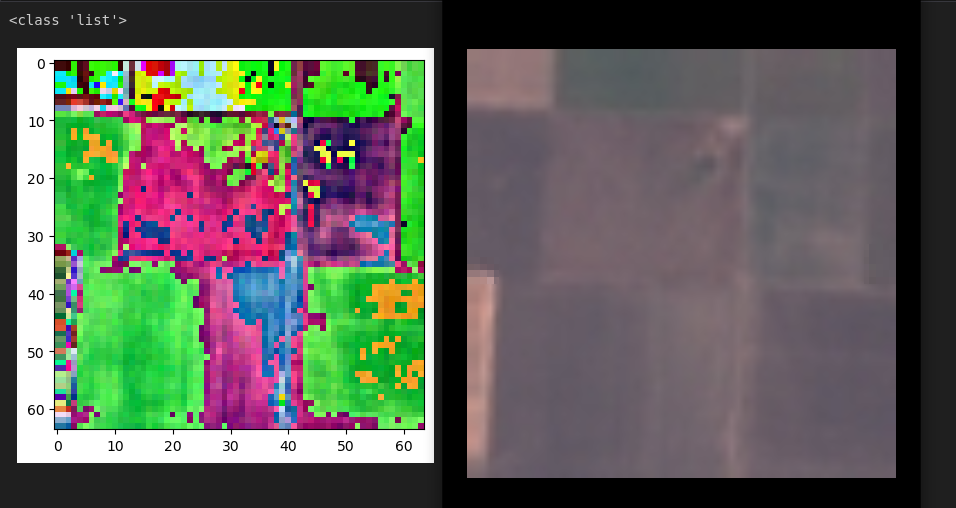
No se por qué no soy capaz de encontrar los colores pero se queda asi...

In [5]:
print(np.array(dataset['train'][123]['raw_data']).shape)

(64, 64, 4)


In [8]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
mean=image_processor.image_mean
std=image_processor.image_std

# esto lo añadí a macheta para que funcione con 4 canales
mean = [0.5, mean[0],mean[1],mean[2]] #NIR R G B
std = [0.25, std[0],std[1],std[2]] #NIR R G B
mod_image_processor = image_processor
mod_image_processor.image_std = std
mod_image_processor.image_mean = mean
print(mod_image_processor)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.25,
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [9]:
# Load model directly
import torch
import numpy as np
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, SwinConfig
from datasets import load_dataset 
from evaluate import load
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
metric = load("accuracy")

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)


normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")




# BEFORE I CALL IT I NEED TO MAKE SURE THAT IT IS A NUMPY ARRAY
train_transforms = Compose(
        [
            ToTensor(),
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            ToTensor(),
            Resize(size),
            CenterCrop(crop_size),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    #"""Apply train_transforms across a batch."""
    #example_batch["pixel_values"] = [
    #    train_transforms(image.convert("RGB")) for image in example_batch["image"]
    #]
    """
    example_batch["pixel_values"] = []
    for image in example_batch["raw_data"]:
        array = np.array(image)
        # cast it to iunt8
        array = array.astype(np.uint8)
        array = train_transforms(array)
        example_batch["pixel_values"].append(array)
    """
    example_batch["pixel_values"] = [train_transforms(np.array(image).astype(np.uint8)) for image in example_batch["raw_data"]]

    return example_batch

def preprocess_val(example_batch):
    #"""Apply val_transforms across a batch."""
    #example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    
    """
    example_batch["pixel_values"] = []
    for image in example_batch["raw_data"]:
        array = np.array(image)
        # cast it to iunt8
        array = array.astype(np.uint8)
        array = val_transforms(array)
        example_batch["pixel_values"].append(array)
        print(example_batch)
    """
    example_batch["pixel_values"] = [val_transforms(np.array(image).astype(np.uint8)) for image in example_batch["raw_data"]]

    return example_batch



splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

print(splits)
print(train_ds)
print(val_ds)
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'raw_data'],
        num_rows: 24300
    })
    test: Dataset({
        features: ['image', 'label', 'raw_data'],
        num_rows: 2700
    })
})
Dataset({
    features: ['image', 'label', 'raw_data'],
    num_rows: 24300
})
Dataset({
    features: ['image', 'label', 'raw_data'],
    num_rows: 2700
})


In [10]:

# Load and modify the model configuration
config = SwinConfig.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
config.embed_dim = 96  # change embedding dimension to mask2former value
config.num_heads = [3, 6, 12, 24]  # change number of heads for each stage to mask2former value
config.depths = [2, 2, 6, 2]  # change depths for each stage to mask2former value
config.window_size = 7  # change window size to mask2former value
config.ape = False  # change absolute position embedding to mask2former value
config.drop_path_rate = 0.3  # change drop path rate to mask2former value
config.patch_norm = True  # change patch norm to mask2former value
config.id2label = id2label # add the labels of the dataset eurosat, we have 10 classes instead of 1000
config.label2id = label2id # add the labels of the dataset eurosat, we have 10 classes instead of 1000
config.num_channels = 4 # If I can get the multispectral images to work, I will have to change this value so that it uses the NIR value


In [11]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    config=config,
    #label2id=label2id,
    #id2label=id2label,
    ignore_mismatched_sizes=True,
)


model_name = model_checkpoint.split("/")[-1]
batch_size = 24
args = TrainingArguments(
    f"{model_name}-multiFINAL",
    remove_unused_columns=False,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size = batch_size,
    gradient_accumulation_steps = 4,
    per_device_eval_batch_size = batch_size,
    num_train_epochs=12,# en el tuto pone 3 pero tarda mucho
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)




# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)



# define a collate_fn, which will be used to batch examples together. Each batch consists of 2 keys, namely pixel_values and labels.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)


train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- swin.embeddings.patch_embeddings.projection.weight: found shape torch.Size([96, 3, 4, 4]) in the checkpoint and torch.Size([96, 4, 4, 4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3036 [00:00<?, ?it/s]

{'loss': 2.3187, 'grad_norm': 4.742274284362793, 'learning_rate': 1.6447368421052632e-06, 'epoch': 0.04}
{'loss': 2.3052, 'grad_norm': 4.8512282371521, 'learning_rate': 3.2894736842105265e-06, 'epoch': 0.08}
{'loss': 2.2878, 'grad_norm': 4.113448143005371, 'learning_rate': 4.9342105263157895e-06, 'epoch': 0.12}
{'loss': 2.2701, 'grad_norm': 4.430218696594238, 'learning_rate': 6.578947368421053e-06, 'epoch': 0.16}
{'loss': 2.2471, 'grad_norm': 5.238030910491943, 'learning_rate': 8.223684210526317e-06, 'epoch': 0.2}
{'loss': 2.2148, 'grad_norm': 4.992515563964844, 'learning_rate': 9.868421052631579e-06, 'epoch': 0.24}
{'loss': 2.1541, 'grad_norm': 7.009899616241455, 'learning_rate': 1.1513157894736843e-05, 'epoch': 0.28}
{'loss': 2.0572, 'grad_norm': 9.491822242736816, 'learning_rate': 1.3157894736842106e-05, 'epoch': 0.32}
{'loss': 1.9785, 'grad_norm': 9.048705101013184, 'learning_rate': 1.4802631578947368e-05, 'epoch': 0.36}
{'loss': 1.8498, 'grad_norm': 117.4753189086914, 'learning_ra

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.0218560695648193, 'eval_accuracy': 0.62, 'eval_runtime': 32.4564, 'eval_samples_per_second': 83.189, 'eval_steps_per_second': 3.482, 'epoch': 1.0}
{'loss': 1.1766, 'grad_norm': 11.549492835998535, 'learning_rate': 4.2763157894736847e-05, 'epoch': 1.03}
{'loss': 1.1836, 'grad_norm': 18.034963607788086, 'learning_rate': 4.440789473684211e-05, 'epoch': 1.07}
{'loss': 1.1518, 'grad_norm': 13.05733585357666, 'learning_rate': 4.605263157894737e-05, 'epoch': 1.11}
{'loss': 1.2064, 'grad_norm': 12.482882499694824, 'learning_rate': 4.769736842105263e-05, 'epoch': 1.15}
{'loss': 1.1752, 'grad_norm': 16.952451705932617, 'learning_rate': 4.9342105263157894e-05, 'epoch': 1.18}
{'loss': 1.1486, 'grad_norm': 18.514406204223633, 'learning_rate': 4.9890190336749635e-05, 'epoch': 1.22}
{'loss': 1.1315, 'grad_norm': 13.660289764404297, 'learning_rate': 4.970717423133236e-05, 'epoch': 1.26}
{'loss': 1.0512, 'grad_norm': 9.417232513427734, 'learning_rate': 4.952415812591508e-05, 'epoch': 1.

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.6609333157539368, 'eval_accuracy': 0.7596296296296297, 'eval_runtime': 33.039, 'eval_samples_per_second': 81.722, 'eval_steps_per_second': 3.42, 'epoch': 2.0}
{'loss': 0.8498, 'grad_norm': 15.929291725158691, 'learning_rate': 4.6229868228404096e-05, 'epoch': 2.01}
{'loss': 0.8556, 'grad_norm': 17.095312118530273, 'learning_rate': 4.604685212298683e-05, 'epoch': 2.05}
{'loss': 0.8171, 'grad_norm': 8.64382553100586, 'learning_rate': 4.586383601756955e-05, 'epoch': 2.09}
{'loss': 0.842, 'grad_norm': 13.875279426574707, 'learning_rate': 4.5680819912152275e-05, 'epoch': 2.13}
{'loss': 0.7758, 'grad_norm': 8.006183624267578, 'learning_rate': 4.5497803806734994e-05, 'epoch': 2.17}
{'loss': 0.8796, 'grad_norm': 12.44916820526123, 'learning_rate': 4.531478770131772e-05, 'epoch': 2.21}
{'loss': 0.7993, 'grad_norm': 16.677135467529297, 'learning_rate': 4.513177159590044e-05, 'epoch': 2.25}
{'loss': 0.8288, 'grad_norm': 14.852494239807129, 'learning_rate': 4.4948755490483165e-05, '

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.4760688841342926, 'eval_accuracy': 0.8240740740740741, 'eval_runtime': 33.1894, 'eval_samples_per_second': 81.351, 'eval_steps_per_second': 3.405, 'epoch': 3.0}
{'loss': 0.7077, 'grad_norm': 13.172025680541992, 'learning_rate': 4.165446559297219e-05, 'epoch': 3.0}
{'loss': 0.703, 'grad_norm': 17.319360733032227, 'learning_rate': 4.147144948755491e-05, 'epoch': 3.04}
{'loss': 0.7354, 'grad_norm': 11.157282829284668, 'learning_rate': 4.128843338213763e-05, 'epoch': 3.08}
{'loss': 0.6449, 'grad_norm': 11.338555335998535, 'learning_rate': 4.110541727672035e-05, 'epoch': 3.12}
{'loss': 0.6829, 'grad_norm': 12.531622886657715, 'learning_rate': 4.092240117130308e-05, 'epoch': 3.16}
{'loss': 0.7538, 'grad_norm': 11.896467208862305, 'learning_rate': 4.07393850658858e-05, 'epoch': 3.2}
{'loss': 0.6503, 'grad_norm': 12.260625839233398, 'learning_rate': 4.0556368960468524e-05, 'epoch': 3.24}
{'loss': 0.6851, 'grad_norm': 9.588528633117676, 'learning_rate': 4.037335285505124e-05, 'e

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.3955176770687103, 'eval_accuracy': 0.8555555555555555, 'eval_runtime': 33.252, 'eval_samples_per_second': 81.198, 'eval_steps_per_second': 3.398, 'epoch': 4.0}
{'loss': 0.5931, 'grad_norm': 13.861628532409668, 'learning_rate': 3.689604685212299e-05, 'epoch': 4.03}
{'loss': 0.5873, 'grad_norm': 9.82215404510498, 'learning_rate': 3.671303074670571e-05, 'epoch': 4.07}
{'loss': 0.6015, 'grad_norm': 11.29532527923584, 'learning_rate': 3.653001464128844e-05, 'epoch': 4.11}
{'loss': 0.6081, 'grad_norm': 11.142501831054688, 'learning_rate': 3.6346998535871156e-05, 'epoch': 4.15}
{'loss': 0.6318, 'grad_norm': 11.347247123718262, 'learning_rate': 3.616398243045388e-05, 'epoch': 4.19}
{'loss': 0.6358, 'grad_norm': 17.896862030029297, 'learning_rate': 3.59809663250366e-05, 'epoch': 4.23}
{'loss': 0.6568, 'grad_norm': 8.830268859863281, 'learning_rate': 3.579795021961933e-05, 'epoch': 4.26}
{'loss': 0.6157, 'grad_norm': 11.824596405029297, 'learning_rate': 3.5614934114202054e-05, 'e

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.37833207845687866, 'eval_accuracy': 0.8640740740740741, 'eval_runtime': 33.3339, 'eval_samples_per_second': 80.999, 'eval_steps_per_second': 3.39, 'epoch': 5.0}
{'loss': 0.6376, 'grad_norm': 9.023229598999023, 'learning_rate': 3.232064421669107e-05, 'epoch': 5.01}
{'loss': 0.613, 'grad_norm': 10.212570190429688, 'learning_rate': 3.2137628111273795e-05, 'epoch': 5.05}
{'loss': 0.5478, 'grad_norm': 11.201325416564941, 'learning_rate': 3.1954612005856515e-05, 'epoch': 5.09}
{'loss': 0.5557, 'grad_norm': 9.924933433532715, 'learning_rate': 3.177159590043924e-05, 'epoch': 5.13}
{'loss': 0.5099, 'grad_norm': 8.402480125427246, 'learning_rate': 3.158857979502196e-05, 'epoch': 5.17}
{'loss': 0.5325, 'grad_norm': 15.7739839553833, 'learning_rate': 3.1405563689604686e-05, 'epoch': 5.21}
{'loss': 0.5463, 'grad_norm': 11.12579345703125, 'learning_rate': 3.122254758418741e-05, 'epoch': 5.25}
{'loss': 0.4798, 'grad_norm': 7.001697540283203, 'learning_rate': 3.103953147877013e-05, 'ep

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.3590399920940399, 'eval_accuracy': 0.8729629629629629, 'eval_runtime': 33.5804, 'eval_samples_per_second': 80.404, 'eval_steps_per_second': 3.365, 'epoch': 6.0}
{'loss': 0.5245, 'grad_norm': 13.068781852722168, 'learning_rate': 2.774524158125915e-05, 'epoch': 6.0}
{'loss': 0.4835, 'grad_norm': 8.069328308105469, 'learning_rate': 2.7562225475841873e-05, 'epoch': 6.04}
{'loss': 0.5109, 'grad_norm': 10.542325019836426, 'learning_rate': 2.7379209370424596e-05, 'epoch': 6.08}
{'loss': 0.5184, 'grad_norm': 10.111294746398926, 'learning_rate': 2.719619326500732e-05, 'epoch': 6.12}
{'loss': 0.5517, 'grad_norm': 9.16072940826416, 'learning_rate': 2.7013177159590048e-05, 'epoch': 6.16}
{'loss': 0.5129, 'grad_norm': 16.31070899963379, 'learning_rate': 2.683016105417277e-05, 'epoch': 6.2}
{'loss': 0.4837, 'grad_norm': 9.953481674194336, 'learning_rate': 2.6647144948755493e-05, 'epoch': 6.24}
{'loss': 0.5673, 'grad_norm': 10.037005424499512, 'learning_rate': 2.6464128843338216e-05, 

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.3097951114177704, 'eval_accuracy': 0.8918518518518519, 'eval_runtime': 33.2559, 'eval_samples_per_second': 81.189, 'eval_steps_per_second': 3.398, 'epoch': 7.0}
{'loss': 0.4921, 'grad_norm': 14.073285102844238, 'learning_rate': 2.2986822840409958e-05, 'epoch': 7.03}
{'loss': 0.4856, 'grad_norm': 19.027952194213867, 'learning_rate': 2.280380673499268e-05, 'epoch': 7.07}
{'loss': 0.5164, 'grad_norm': 9.43011474609375, 'learning_rate': 2.2620790629575403e-05, 'epoch': 7.11}
{'loss': 0.465, 'grad_norm': 12.835615158081055, 'learning_rate': 2.243777452415813e-05, 'epoch': 7.15}
{'loss': 0.472, 'grad_norm': 6.8167877197265625, 'learning_rate': 2.2254758418740852e-05, 'epoch': 7.19}
{'loss': 0.4727, 'grad_norm': 9.848868370056152, 'learning_rate': 2.2071742313323575e-05, 'epoch': 7.23}
{'loss': 0.4533, 'grad_norm': 15.072882652282715, 'learning_rate': 2.1888726207906297e-05, 'epoch': 7.27}
{'loss': 0.4989, 'grad_norm': 12.877419471740723, 'learning_rate': 2.170571010248902e-05

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.3187694847583771, 'eval_accuracy': 0.89, 'eval_runtime': 33.5425, 'eval_samples_per_second': 80.495, 'eval_steps_per_second': 3.369, 'epoch': 8.0}
{'loss': 0.4679, 'grad_norm': 13.695027351379395, 'learning_rate': 1.841142020497804e-05, 'epoch': 8.02}
{'loss': 0.4216, 'grad_norm': 14.744754791259766, 'learning_rate': 1.822840409956076e-05, 'epoch': 8.06}
{'loss': 0.4002, 'grad_norm': 7.434242248535156, 'learning_rate': 1.8045387994143488e-05, 'epoch': 8.09}
{'loss': 0.4571, 'grad_norm': 15.110482215881348, 'learning_rate': 1.786237188872621e-05, 'epoch': 8.13}
{'loss': 0.425, 'grad_norm': 7.723679065704346, 'learning_rate': 1.7679355783308933e-05, 'epoch': 8.17}
{'loss': 0.4077, 'grad_norm': 11.513921737670898, 'learning_rate': 1.7496339677891656e-05, 'epoch': 8.21}
{'loss': 0.4319, 'grad_norm': 10.189903259277344, 'learning_rate': 1.731332357247438e-05, 'epoch': 8.25}
{'loss': 0.4639, 'grad_norm': 10.041694641113281, 'learning_rate': 1.71303074670571e-05, 'epoch': 8.29

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.2698388695716858, 'eval_accuracy': 0.904074074074074, 'eval_runtime': 34.8701, 'eval_samples_per_second': 77.43, 'eval_steps_per_second': 3.241, 'epoch': 9.0}
{'loss': 0.3894, 'grad_norm': 8.807290077209473, 'learning_rate': 1.383601756954612e-05, 'epoch': 9.0}
{'loss': 0.4491, 'grad_norm': 15.362948417663574, 'learning_rate': 1.3653001464128845e-05, 'epoch': 9.04}
{'loss': 0.4529, 'grad_norm': 9.32771110534668, 'learning_rate': 1.3469985358711567e-05, 'epoch': 9.08}
{'loss': 0.44, 'grad_norm': 14.342710494995117, 'learning_rate': 1.328696925329429e-05, 'epoch': 9.12}
{'loss': 0.4088, 'grad_norm': 11.41982364654541, 'learning_rate': 1.3103953147877013e-05, 'epoch': 9.16}
{'loss': 0.4254, 'grad_norm': 10.913473129272461, 'learning_rate': 1.2920937042459739e-05, 'epoch': 9.2}
{'loss': 0.4141, 'grad_norm': 10.944832801818848, 'learning_rate': 1.2737920937042461e-05, 'epoch': 9.24}
{'loss': 0.418, 'grad_norm': 9.705222129821777, 'learning_rate': 1.2554904831625182e-05, 'epo

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.25702419877052307, 'eval_accuracy': 0.9081481481481481, 'eval_runtime': 33.5497, 'eval_samples_per_second': 80.478, 'eval_steps_per_second': 3.368, 'epoch': 10.0}
{'loss': 0.3982, 'grad_norm': 7.245521068572998, 'learning_rate': 9.077598828696926e-06, 'epoch': 10.03}
{'loss': 0.4242, 'grad_norm': 14.810235977172852, 'learning_rate': 8.894582723279648e-06, 'epoch': 10.07}
{'loss': 0.3971, 'grad_norm': 23.416786193847656, 'learning_rate': 8.711566617862373e-06, 'epoch': 10.11}
{'loss': 0.394, 'grad_norm': 13.516730308532715, 'learning_rate': 8.528550512445096e-06, 'epoch': 10.15}
{'loss': 0.3924, 'grad_norm': 8.92953872680664, 'learning_rate': 8.34553440702782e-06, 'epoch': 10.19}
{'loss': 0.3892, 'grad_norm': 6.9586663246154785, 'learning_rate': 8.162518301610541e-06, 'epoch': 10.23}
{'loss': 0.4746, 'grad_norm': 9.230804443359375, 'learning_rate': 7.979502196193265e-06, 'epoch': 10.27}
{'loss': 0.4132, 'grad_norm': 9.940635681152344, 'learning_rate': 7.796486090775988e-

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.25717371702194214, 'eval_accuracy': 0.9088888888888889, 'eval_runtime': 33.6561, 'eval_samples_per_second': 80.223, 'eval_steps_per_second': 3.357, 'epoch': 11.0}
{'loss': 0.3765, 'grad_norm': 9.617626190185547, 'learning_rate': 4.502196193265008e-06, 'epoch': 11.02}
{'loss': 0.3809, 'grad_norm': 11.100878715515137, 'learning_rate': 4.319180087847731e-06, 'epoch': 11.06}
{'loss': 0.3753, 'grad_norm': 11.117266654968262, 'learning_rate': 4.136163982430454e-06, 'epoch': 11.1}
{'loss': 0.3642, 'grad_norm': 8.387928009033203, 'learning_rate': 3.9531478770131775e-06, 'epoch': 11.14}
{'loss': 0.367, 'grad_norm': 10.951154708862305, 'learning_rate': 3.7701317715959007e-06, 'epoch': 11.17}
{'loss': 0.4102, 'grad_norm': 10.467303276062012, 'learning_rate': 3.587115666178624e-06, 'epoch': 11.21}
{'loss': 0.3424, 'grad_norm': 6.990927696228027, 'learning_rate': 3.4040995607613473e-06, 'epoch': 11.25}
{'loss': 0.3739, 'grad_norm': 10.199886322021484, 'learning_rate': 3.221083455344

  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 0.24406524002552032, 'eval_accuracy': 0.9155555555555556, 'eval_runtime': 33.8011, 'eval_samples_per_second': 79.879, 'eval_steps_per_second': 3.343, 'epoch': 11.99}
{'train_runtime': 4739.0054, 'train_samples_per_second': 61.532, 'train_steps_per_second': 0.641, 'train_loss': 0.6567547801140897, 'epoch': 11.99}
***** train metrics *****
  epoch                    =      11.9882
  total_flos               = 8994302351GF
  train_loss               =       0.6568
  train_runtime            =   1:18:59.00
  train_samples_per_second =       61.532
  train_steps_per_second   =        0.641


  0%|          | 0/113 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =    11.9882
  eval_accuracy           =     0.9156
  eval_loss               =     0.2441
  eval_runtime            = 0:00:33.38
  eval_samples_per_second =     80.882
  eval_steps_per_second   =      3.385


# INFERENCE

https://paperswithcode.com/dataset/bigearthnet

https://github.com/huggingface/transformers/issues/26403

https://github.com/facebookresearch/dinov2/blob/main/notebooks/semantic_segmentation.ipynb

https://huggingface.co/docs/transformers/main_classes/backbones

In [225]:
def read_rawb_NirRGB(file_name):
    with open(file_name, "rb") as f:
        sizes = np.fromfile(f, dtype=np.int32, count=3)
        image_data = np.fromfile(f, dtype=np.int32)
        image = image_data.reshape(sizes)
        
        image = image.astype(np.uint8)
        
    return image

def read_rawb_RGB(file_name):
    img = read_rawb_NirRGB(file_name)
    
    return img[:, :, 1:4]  # Delete Nir channel #MODIFIED SO IT KEEPS NIR, it should be 1:4  (NIR-R-G-B)

In [347]:
from PIL import Image
import requests

#url = 'https://huggingface.co/nielsr/convnext-tiny-finetuned-eurostat/resolve/main/forest.png'
image = read_rawb_NirRGB("/home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_rawb/GF2_PMS2__L1A0000564691-MSS2_1.rawb") # NIR R G B
image.shape

(3454, 3650, 4)

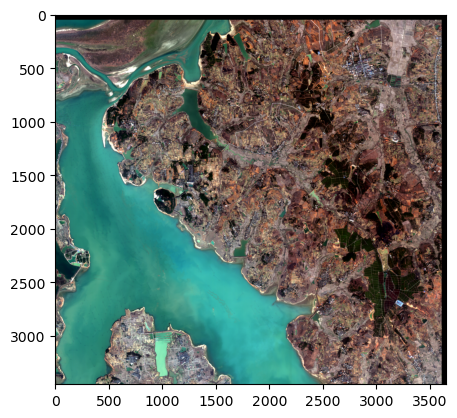

In [348]:
# show the image
plt.imshow(image[:, :, [1,2,3]]) # NIR R G B
plt.show()

In [349]:
from torchvision.transforms import ToTensor, Normalize, RandomCrop

image = ToTensor()(image)
print(image.shape)
normalized_image = normalize(image)
print(normalized_image.shape) 

cropped_image = RandomCrop(224)(normalized_image)
print(cropped_image.shape)

cropped_image = cropped_image.reshape(1, 4, 224 ,224)

torch.Size([4, 3454, 3650])
torch.Size([4, 3454, 3650])
torch.Size([4, 224, 224])


In [350]:
#image = ToTensor()(image)
#print(image.shape)
#normalized_image = normalize(image)
#print(normalized_image.shape) 


#cropped_image = RandomResizedCrop(224)(normalized_image)
#print(cropped_image.shape)
#cropped_image = cropped_image.reshape(1,4,224,224)
#print(cropped_image.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


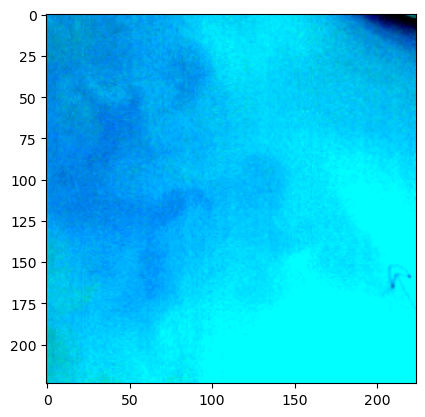

In [351]:
# show cropped image
plt.imshow(cropped_image[0, 1:4].permute(1, 2, 0))
plt.show()

In [352]:
# create a ransformers.image_processing_base.BatchFeature
encoding = {"pixel_values": cropped_image}
print(type(encoding))

<class 'dict'>


In [353]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

path = "/home/pablo.canosa/finetuning_trials/swin-tiny-patch4-window7-224-multiFINAL"

#image_processor = AutoImageProcessor.from_pretrained(path)
model = AutoModelForImageClassification.from_pretrained(path)

In [354]:
# Esto no funciona con las imagenes de 4 canales
#encoding = image_processor(image, return_tensors="pt")
#print(encoding.pixel_values.shape)

In [355]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [356]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: SeaLake
